In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import fredapi as fa
from scipy import stats
import numpy as np
sns.set()

In [4]:
btcusd = yf.download("BTC-USD", start="2014-09-18", end="2022-12-31", auto_adjust = False)['Adj Close']
btcusd_returns = btcusd.pct_change().dropna()

[*********************100%***********************]  1 of 1 completed


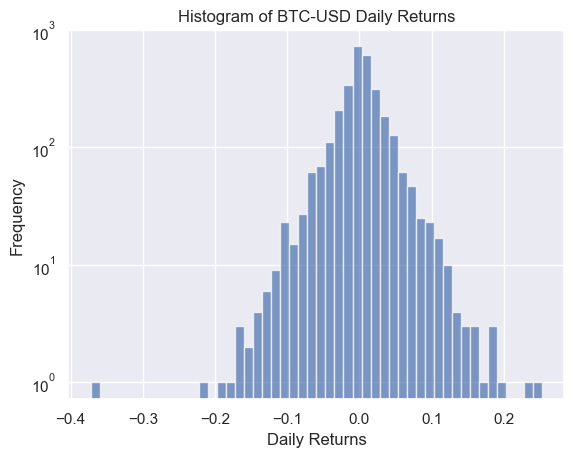

In [6]:
plt.hist(x = btcusd_returns, bins=50, log = True, alpha = 0.7)
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.title('Histogram of BTC-USD Daily Returns')
plt.show()

## **Value at Risk (VaR)**
* Historical Method
* Parametric Method
* Monte Carlo Simulation

## 1. Historical Method

In [7]:
# It takes two arguments: 1. a series of daily returns, and 2. a confidence level.

def getHistoricalVar(returns, confidenceLevel):
    var = np.quantile(returns, 1 - confidenceLevel)
    print(
        f"The Historical VaR with confidence {confidenceLevel} is {round(100 * var, 3)}% \n"
    )

In [8]:
getHistoricalVar(btcusd_returns, 0.90)
getHistoricalVar(btcusd_returns, 0.95)
getHistoricalVar(btcusd_returns, 0.99)

The Historical VaR with confidence 0.9 is -3.717% 

The Historical VaR with confidence 0.95 is -6.0% 

The Historical VaR with confidence 0.99 is -10.57% 



#### Interpretation
* VaR at 90% confidence = -3.717% → On a typical day, there’s a 10% chance that BTC could lose more than 3.717% of its value.
* VaR at 95% confidence = -6.0% → On a typical day, there’s a 5% chance of losing more than 6%.
* VaR at 99% confidence = -10.57% → On a typical day, there’s a 1% chance of losing more than 10.57%.


## 2. Parametric Method

Assuming that returns are Gaussian we can leverage the `norm.ppf()` function from `scipy.stats` module. The percent point function (ppf) is actually the inverse cumulative distribution function (CDF), and it allows us to compute the quantile that corresponds to a given confidence level.

In [15]:
mean = btcusd_returns.mean()
std = btcusd_returns.std()

var_90 = stats.norm.ppf(0.1, mean, std)[0]
var_95 = stats.norm.ppf(0.05, mean, std)[0]
var_99 = stats.norm.ppf(0.01, mean, std)[0]

print(f"The parametric VaR assuming a normal distribution with a 90% confidence interval, is {round(100 * var_90, 3)} \n")
print(f"The parametric VaR assuming a normal distribution with a 95% confidence interval, is {round(100 * var_95, 3)} \n")
print(f"The parametric VaR assuming a normal distribution with a 99% confidence interval, is {round(100 * var_99, 3)} \n")

The parametric VaR assuming a normal distribution with a 90% confidence interval, is -4.716 

The parametric VaR assuming a normal distribution with a 95% confidence interval, is -6.108 

The parametric VaR assuming a normal distribution with a 99% confidence interval, is -8.72 



However, we never see perfect Gaussian returns and more often than not we encounter returns with heavier tails, which is well approximated by Student's-t distribution instead. 

In [16]:
# It takes three arguments: 1. a series of daily returns, 2. degrees of freedom, and 3. a confidence level.
# The function returns the VaR calculated using the Student's t-distribution.
def getStudentVar(returns, dof, confidenceLevel):
    mean = returns.mean()
    std = returns.std()
    var = np.sqrt((dof - 2) / dof) * stats.t.ppf(1 - confidenceLevel, dof) * std + mean
    return (100 * var).round(3)

In [17]:
print(f"The parametric VaR using t-distribution with a confidence interval 0.9, is {getStudentVar(btcusd_returns, 5, 0.9)}% \n")
print(f"The parametric VaR using t-distribution with a confidence interval 0.95, is {getStudentVar(btcusd_returns, 5, 0.95)}% \n")
print(f"The parametric VaR using t-distribution with a confidence interval 0.99, is {getStudentVar(btcusd_returns, 5, 0.99)}% \n")

The parametric VaR using t-distribution with a confidence interval 0.9, is Ticker
BTC-USD   -4.186
dtype: float64% 

The parametric VaR using t-distribution with a confidence interval 0.95, is Ticker
BTC-USD   -5.786
dtype: float64% 

The parametric VaR using t-distribution with a confidence interval 0.99, is Ticker
BTC-USD   -9.793
dtype: float64% 



## 3. Monte Carlo VaR

In an event where we have incomplete or insufficient data we can hypothesize a distribution that generates the data and run simulations using those distributional assumptions. This method is called *Monte Carlo VaR*.

In [18]:
# Parameters
initial_investment = 100000  # Initial portfolio value (in dollars)
mean_return = 0.0005  # Daily mean return of the asset (e.g., 0.05%)
volatility = 0.02  # Daily volatility (not annual!) is 2%
days = 1  # 1 day time horizon
num_simulations = 10000  # Number of Monte Carlo simulations
confidence_level = 0.95  # Confidence level for VaR (e.g., 95%)

In [20]:
# Generate random returns based on normal distribution
np.random.seed(2026)  # For reproducibility
random_returns = np.random.normal(loc=mean_return * days, scale=volatility * np.sqrt(days), size=num_simulations)

# Calculate portfolio values at the end of the simulation
portfolio_end_values = initial_investment * (1 + random_returns)

# Calculate profit and loss (P&L)
portfolio_pnl = portfolio_end_values - initial_investment

# Calculate the VaR at the specified confidence level
VaR = np.percentile(portfolio_pnl, (1 - confidence_level) * 100)

# Output the results
print(f"Value at Risk (VaR) at {confidence_level * 100}% confidence level: -${abs(VaR):,.2f} (-{round((abs(VaR) / initial_investment) * 100, 2)}%)")

Value at Risk (VaR) at 95.0% confidence level: -$3,228.90 (-3.23%)


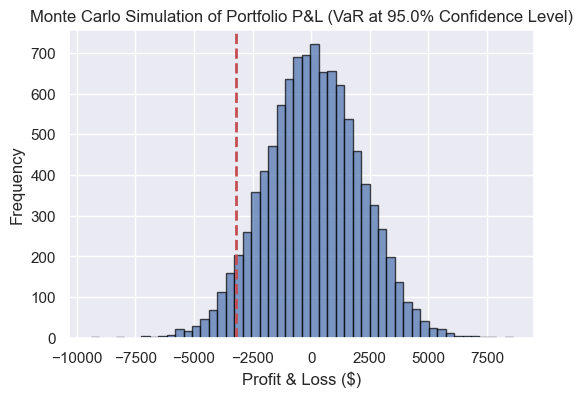

In [22]:
#Plot the distribution of portfolio P&L
plt.figure(figsize=(6, 4))
plt.hist(portfolio_pnl, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=VaR, color='r', linestyle='dashed', linewidth=2)
plt.title(f"Monte Carlo Simulation of Portfolio P&L (VaR at {confidence_level * 100}% Confidence Level)")
plt.xlabel('Profit & Loss ($)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()